In [1]:
import numpy as np
import cv2
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

In [2]:
annotations = pd.read_csv('/kaggle/input/tiny-lisa-traffic-sign-detection-dataset/db_lisa_tiny/annotations.csv')
annotations.head()

filename   x1   y1   x2   y2 class
0  sample_001.png  190   40  211   63  stop
1  sample_002.png    4  246   43  283  stop
2  sample_003.png  389  286  418  314  stop
3  sample_004.png  307  243  315  251  stop
4  sample_005.png  377  249  398  270  stop

In [3]:
# Shuffle the dataset
annotations = annotations.sample(frac=1).reset_index(drop=True)

In [4]:
annotations['class'].value_counts()

class
stop                  210
speedLimit35          110
keepRight             110
pedestrianCrossing    100
merge                 100
signalAhead           100
speedLimit25           80
yieldAhead             45
yield                  45
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
annotations['class'] = label_encoder.fit_transform(annotations['class'])

annotations.head()

filename   x1   y1   x2   y2  class
0  sample_054.png  519   52  543   75      6
1  sample_741.png  522  202  548  233      5
2  sample_518.png  466  267  496  296      2
3  sample_146.png  603   36  632   63      6
4  sample_120.png  299  251  337  287      6

Explore the images

In [6]:
# Function to load images
def load_image(filename):
    image_path = f'/kaggle/input/tiny-lisa-traffic-sign-detection-dataset/db_lisa_tiny/{filename}'
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image file '{filename}' not found at '{image_path}'.")
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    return image, (height, width, channels)

# Function to draw bounding box on the image
def draw_bounding_box(image, x1, y1, x2, y2, color=(255, 0, 0)):
    return cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

In [7]:
# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

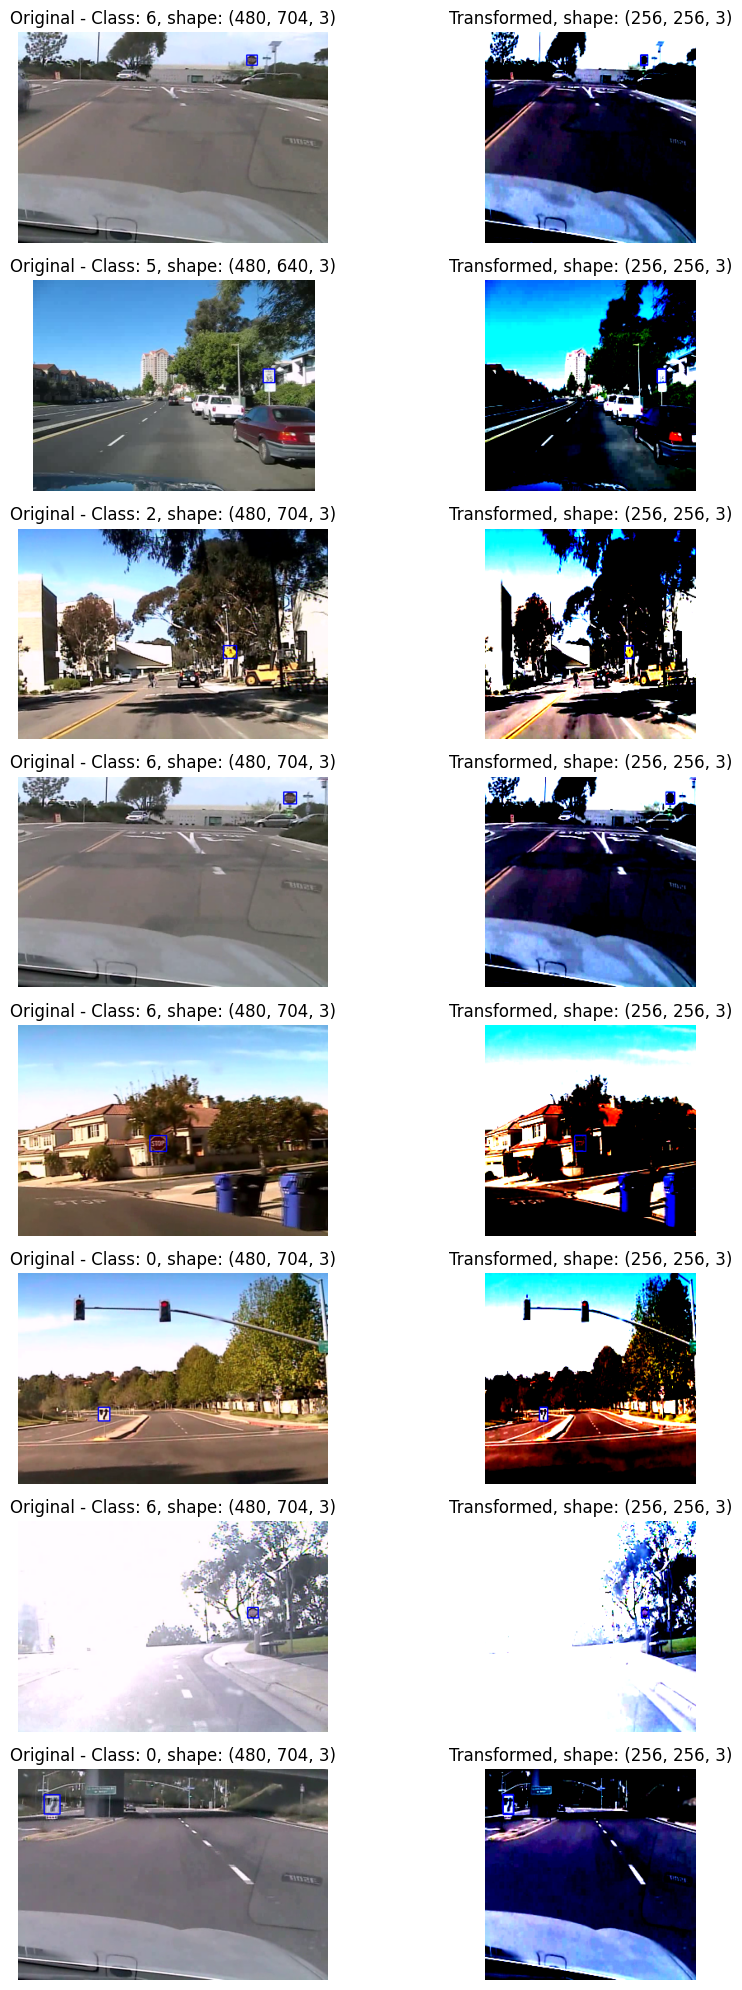

In [8]:
# Number of images to display
num_images = 8

# Create a grid of subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))


for i in range(num_images):
    try:
        # Select the current annotation
        example = annotations.iloc[i]
        image, shape = load_image(example['filename'])
        x1, y1, x2, y2 = example['x1'], example['y1'], example['x2'], example['y2']
        label = example['class']

        # Draw the bounding box on the original image
        draw_bounding_box(image, x1, y1, x2, y2)

        # Convert OpenCV image to PIL image for transformations
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Preprocess the image
        image_tensor = preprocess(image_pil)

        # Display original image
        axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f'Original - Class: {label}, shape: {shape}')
        axes[i, 0].axis('off')

        # Convert tensor back to numpy array for display
        transformed_image = image_tensor.permute(1, 2, 0).numpy()
        transformed_shape = transformed_image.shape

        # Normalize the image for display (undo normalization)
#         transformed_image = (transformed_image * torch.tensor([0.229, 0.224, 0.225]).numpy() + torch.tensor([0.485, 0.456, 0.406]).numpy()).clip(0, 1)

        # Display transformed image
        axes[i, 1].imshow(transformed_image)
        axes[i, 1].set_title(f'Transformed, shape: {transformed_shape}')
        axes[i, 1].axis('off')

    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

# Adjust layout
plt.tight_layout()
plt.show()

Data Preparation and Modelling

In [9]:
class TrafficSignDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
        
        x1 = self.dataframe.iloc[idx, 1]
        y1 = self.dataframe.iloc[idx, 2]
        x2 = self.dataframe.iloc[idx, 3]
        y2 = self.dataframe.iloc[idx, 4]
        label = self.dataframe.iloc[idx, 5]
        
        if self.transform:
            image = self.transform(image)
        
        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.long)
            
        sample = {"image": image, "bbox": [x1, y1, x2, y2], "label": label}
        return sample


In [10]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(annotations, test_size=0.2, random_state=42)
print(f"length of train dataset: {len(train_df)}")
print(f"length of test dataset: {len(test_df)}")

length of train dataset: 720
length of test dataset: 180


In [11]:
# Create dataset and data loader
train_dataset = TrafficSignDataset(dataframe=train_df,
                             image_dir='/kaggle/input/tiny-lisa-traffic-sign-detection-dataset/db_lisa_tiny', 
                             transform=preprocess)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TrafficSignDataset(dataframe=test_df,
                             image_dir='/kaggle/input/tiny-lisa-traffic-sign-detection-dataset/db_lisa_tiny', 
                             transform=preprocess)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the number of batches in each DataLoader
print(f'Number of batches in the train DataLoader: {len(train_data_loader)}')
print(f'Number of batches in the test DataLoader: {len(test_data_loader)}')

Number of batches in the train DataLoader: 23
Number of batches in the test DataLoader: 6


In [12]:
# Iterate through the DataLoader to preview one batch
for batch in train_data_loader:
    images = batch['image']
    bboxes = batch['bbox']
    labels = batch['label']

    # Display batch information
    print(f'Batch size: {len(images)}')

    # Print the shape of the first image tensor in the batch
    print(f'Shape of the first image tensor: {images[0].shape}')

    # Print the first bounding box and label in the batch
    print(f'First bbox: {bboxes[0]}, Label: {labels[0]}')

    # Stop after previewing the first batch
    break


Batch size: 32
Shape of the first image tensor: torch.Size([3, 256, 256])
First bbox: tensor([577, 567,  45, 668, 561, 390, 613, 518, 458, 233, 549, 619, 421, 398,
        587, 660, 481, 562, 636, 340, 208, 395, 603, 359, 467, 452, 557, 103,
        551, 479, 123, 141]), Label: 1


In [13]:
# Define the custom CNN model architecture
class TrafficSignModel(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(in_features=512 * 16 * 16, out_features=1024)  # Adjust the in_features based on the input size
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.drop_fc1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.drop_fc1(x)

        x = self.fc2(x)
        return x

# Instantiate the model
model = TrafficSignModel(num_classes=47)  # Adjust num_classes to the number of traffic sign classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define your training loop here
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_data_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 10 == 0:  # Print every 10 mini-batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_data_loader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    # Evaluate the model after each epoch on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_data_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

print('Finished Training and Testing')

Epoch [1/10], Step [10/23], Loss: 9.6009
Epoch [1/10], Step [20/23], Loss: 4.4040
Epoch [1/10], Test Accuracy: 38.33%
Epoch [2/10], Step [10/23], Loss: 2.0561
Epoch [2/10], Step [20/23], Loss: 1.6666
Epoch [2/10], Test Accuracy: 72.78%
Epoch [3/10], Step [10/23], Loss: 0.8548
Epoch [3/10], Step [20/23], Loss: 0.7912
Epoch [3/10], Test Accuracy: 76.67%
Epoch [4/10], Step [10/23], Loss: 0.5100
Epoch [4/10], Step [20/23], Loss: 0.5049
Epoch [4/10], Test Accuracy: 84.44%
Epoch [5/10], Step [10/23], Loss: 0.3668
Epoch [5/10], Step [20/23], Loss: 0.4315
Epoch [5/10], Test Accuracy: 87.22%
Epoch [6/10], Step [10/23], Loss: 0.2702
Epoch [6/10], Step [20/23], Loss: 0.2819
Epoch [6/10], Test Accuracy: 87.22%
Epoch [7/10], Step [10/23], Loss: 0.2709
Epoch [7/10], Step [20/23], Loss: 0.2490
Epoch [7/10], Test Accuracy: 83.89%
Epoch [8/10], Step [10/23], Loss: 0.2208
Epoch [8/10], Step [20/23], Loss: 0.2009
Epoch [8/10], Test Accuracy: 85.56%
Epoch [9/10], Step [10/23], Loss: 0.2415
Epoch [9/10], S

In [15]:
# Define the function to display the image and the predicted class
def display_image_and_prediction(image_path, model, label_encoder, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the tensor to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_tensor = image_tensor.to(device)

    # Make a prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Convert the predicted class index to the original class label
    original_class = label_encoder.inverse_transform([predicted_class])[0]

    # Display the image and the predicted class label
    plt.imshow(image)
    plt.title(f'Predicted Class: {original_class}')
    plt.xlabel(f'{image_path}')
    plt.axis('off')
    plt.show()

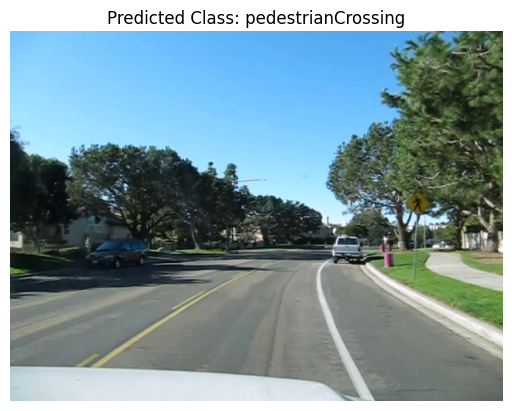

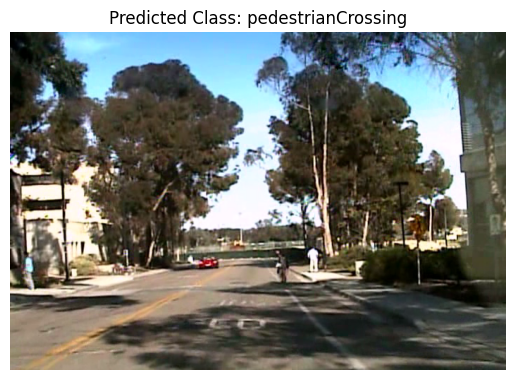

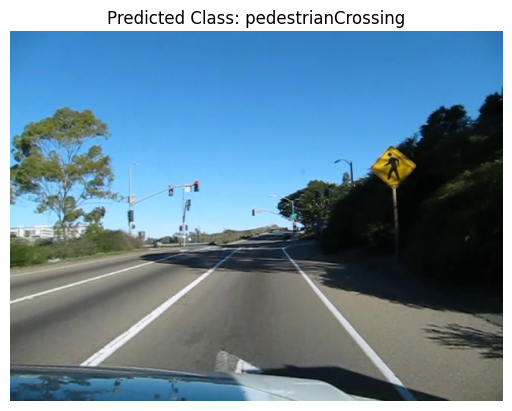

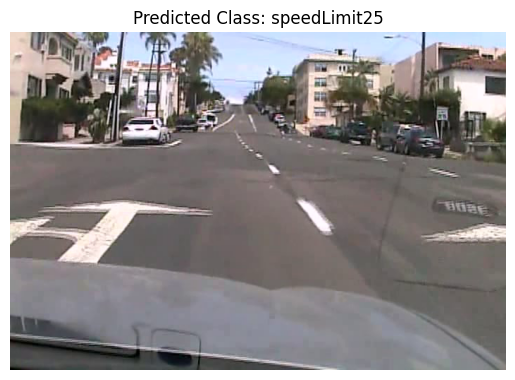

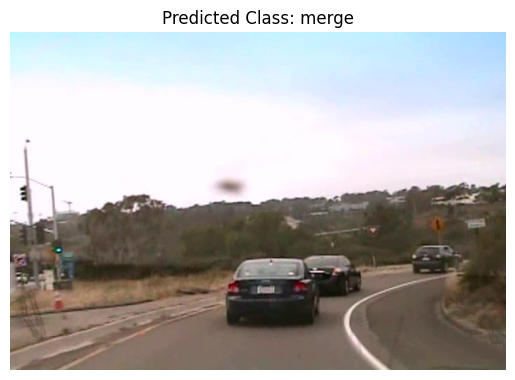

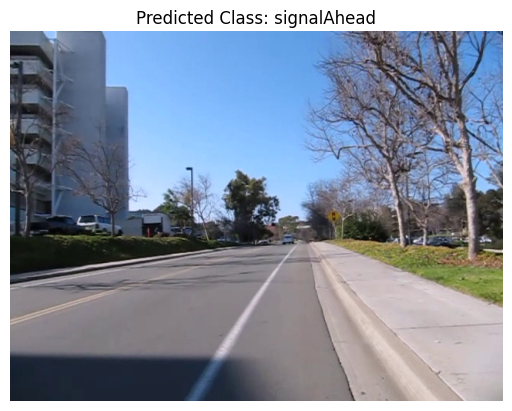

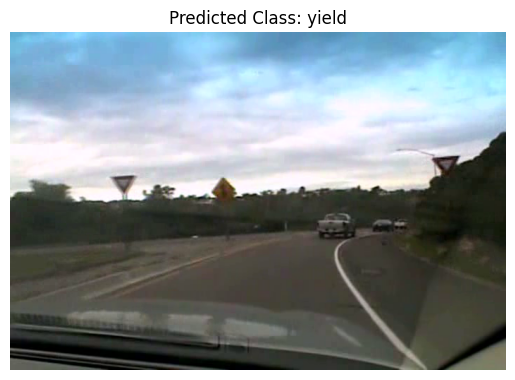

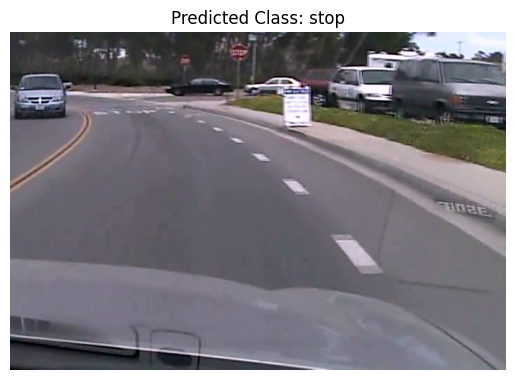

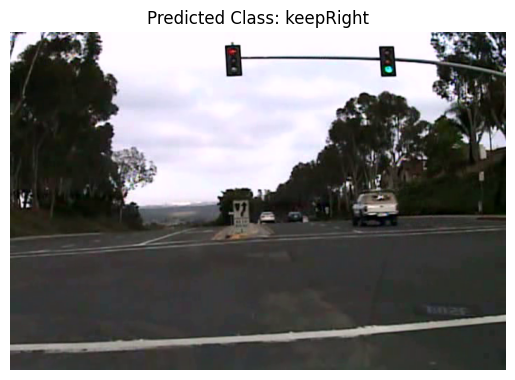

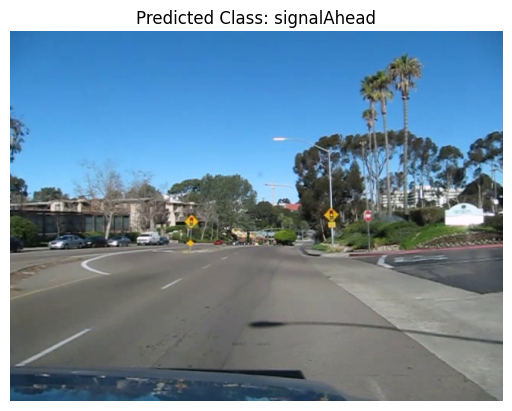

In [16]:
import random
image_dir = "/kaggle/input/tiny-lisa-traffic-sign-detection-dataset/db_lisa_tiny"
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

#randomly select 2 samples from dataset
random_images = random.sample(all_images, 10)

# Display the randomly selected images from dataset and their predictions
for img_path in random_images:
    display_image_and_prediction(img_path, model, label_encoder, preprocess)